## [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network

### Instructor: Nikos Aletras

The goal of this assignment is to develop a Feedforward network for text classification. 

For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)


### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.


### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`


### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
topic_dev = pd.read_csv('data_topic/dev.csv', names=['label', 'text'])
topic_test = pd.read_csv('data_topic/test.csv', names=['label', 'text'])
topic_train = pd.read_csv('data_topic/train.csv', names=['label', 'text'])

topic_dev_texts = list(topic_dev['text'])
topic_train_texts = list(topic_train['text'])
topic_test_texts = list(topic_test['text'])

# Create input representations

To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.

In [3]:
default_stop_words = {
    'a', 'ad', 'after', 'again', 'all', 'also', 'am', 'an', 'and', 'any',
    'are', 'as', 'at', 'be', 'because', 'been', 'being', 'between', 'both',
    'but', 'by', 'can', 'could', 'does', 'each', 'ed', 'eg', 'either', 'etc',
    'even', 'ever', 'every', 'for', 'from', 'had', 'has', 'have', 'he', 'her',
    'hers', 'herself', 'him', 'himself', 'his', 'i', 'ie', 'if', 'in', 'inc',
    'into', 'is', 'it', 'its', 'itself', 'li', 'll', 'ltd', 'may', 'maybe',
    'me', 'might', 'mine', 'minute', 'minutes', 'must', 'my', 'myself',
    'neither', 'nor', 'now', 'of', 'on', 'only', 'or', 'other', 'our', 'ours',
    'ourselves', 'own', 'same', 'seem', 'seemed', 'shall', 'she', 'some',
    'somehow', 'something', 'sometimes', 'somewhat', 'somewhere', 'spoiler',
    'spoilers', 'such', 'suppose', 'that', 'the', 'their', 'theirs', 'them',
    'themselves', 'there', 'these', 'they', 'this', 'those', 'thus', 'to',
    'today', 'tomorrow', 'us', 've', 'vs', 'was', 'we', 'were', 'what',
    'whatever', 'when', 'whenever', 'where', 'whereby', 'which', 'who', 'whom',
    'whose', 'will', 'with', 'yesterday', 'you', 'your', 'yours', 'yourself',
    'yourselves'
}

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

In [4]:
def extract_ngrams(x_raw,
                   ngram_range=(1, 3),
                   token_pattern=r'\b[A-Za-z]{2,}\b',
                   stop_words=default_stop_words,
                   vocab=None):

    tokens = [
        word.lower() for word in re.findall(token_pattern, x_raw)
        if word.lower() not in stop_words
    ]

    ngrams = []

    for n in range(ngram_range[0], ngram_range[1] + 1):
        if n == 1:
            # Create unigram by concatenating list
            ngrams += tokens
        else:
            # Create bigram / trigram by unzipping list
            ngrams += zip(*(tokens[i:] for i in range(n)))

    return [ngram for ngram in ngrams if ngram in vocab] if vocab else ngrams

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

In [5]:
def get_vocab(X_raw,
              ngram_range=(1, 3),
              token_pattern=r'\b[A-Za-z]{2,}\b',
              min_df=1,
              keep_topN=None,
              stop_words=default_stop_words):

    df = Counter()
    ngram_counts = Counter()

    for text in X_raw:
        # A list of ngrams for the given document `text`
        ngram_list = extract_ngrams(text, ngram_range, token_pattern, stop_words)
        
        # Count document frequency
        df.update(set(ngram_list))

        # Count ngram frequency
        ngram_counts.update(ngram for ngram in ngram_list if df[ngram] >= min_df)
    
    # Extract ngram into vocab set
    vocab = {ngram for ngram, _ in ngram_counts.most_common(keep_topN)}

    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [6]:
dev_vocab, _, _ = get_vocab(topic_dev_texts, ngram_range=(1, 1), keep_topN=5000)
train_vocab, _, _ = get_vocab(topic_train_texts, ngram_range=(1, 1), keep_topN=5000)
test_vocab, _, _ = get_vocab(topic_test_texts, ngram_range=(1, 1), keep_topN=5000)

# Set order is random for every new run. Use `sorted` for reproducibility
vocab = sorted(dev_vocab.union(train_vocab).union(test_vocab))

Then, you need to create vocabulary id -> word and word -> id dictionaries for reference:

In [7]:
vocab_id_to_word = dict(enumerate(vocab))
word_to_vocab_id = {v: k for k, v in vocab_id_to_word.items()}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [8]:
topic_dev_uni = [
    extract_ngrams(doc, ngram_range=(1, 1), vocab=vocab)
    for doc in topic_dev_texts
]
topic_train_uni = [
    extract_ngrams(doc, ngram_range=(1, 1), vocab=vocab)
    for doc in topic_train_texts
]
topic_test_uni = [
    extract_ngrams(doc, ngram_range=(1, 1), vocab=vocab)
    for doc in topic_test_texts
]

Then convert them into lists of indices in the vocabulary:

In [9]:
topic_dev_ids = [[word_to_vocab_id[uni] for uni in unigrams]
                 for unigrams in topic_dev_uni]

topic_train_ids = [[word_to_vocab_id[uni] for uni in unigrams]
                   for unigrams in topic_train_uni]

topic_test_ids = [[word_to_vocab_id[uni] for uni in unigrams]
                  for unigrams in topic_test_uni]

Put the labels `Y` for train, dev and test sets into arrays: 

In [10]:
# The labels start from 1, subtract 1 to make them start from 0
topic_dev_labels = np.array(topic_dev['label']) - 1
topic_train_labels = np.array(topic_train['label']) - 1
topic_test_labels = np.array(topic_test['label']) - 1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$


# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [11]:
def network_weights(vocab_size=1000, embedding_dim=300, hidden_dim=[], num_classes=3):
    # fixing random seed for reproducibility
    np.random.seed(123)

    dimensions = [vocab_size, embedding_dim] + hidden_dim + [num_classes]

    # Use "He Weight Initialisation"
    W = [np.random.randn(*size).astype(np.float32) * np.sqrt(2 / (size[0]))
         for size in zip(*(dimensions[i:] for i in range(2)))]

    return W

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [12]:
def softmax(z):
    """
    Compute probability for each class
    """
    e_z = np.exp(z)
    return e_z / np.sum(e_z, axis=1 if e_z.ndim > 1 else None, keepdims=True)

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [13]:
def categorical_loss(y, y_preds):    
    return -np.log(y_preds[y])

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [14]:
def relu(z):
    return np.clip(z, a_min=0, a_max=None)


def relu_derivative(z):
    return np.clip(z, a_min=0, a_max=1)

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [15]:
def dropout_mask(size, dropout_rate):
    return np.random.choice([0, 1], size, p=[dropout_rate, 1 - dropout_rate])

Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h to the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [16]:
def forward_pass(x, W, dropout_rate=0.2):

    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    # Embedding layer
    h_1 = np.mean(W[0][x], axis=0)
    h_vecs.append(h_1)

    a_1 = relu(h_1)
    a_vecs.append(a_1)

    # Apply dropout mask to embedding layer
    dropout_vecs.append(dropout_mask(W[0].shape[1], dropout_rate))
    a_i = a_1 * dropout_vecs[-1]

    # Loop through each hidden layer
    for weights in W[1:-1]:
        h_i = a_i.dot(weights)
        h_vecs.append(h_i)

        a_i = relu(h_i)
        a_vecs.append(a_i)

        dropout_vecs.append(dropout_mask(weights.shape[1], dropout_rate))
        a_i *= dropout_vecs[-1]

    # Output layer: make prediction
    y = softmax(a_i.dot(W[-1]))

    return {'h': h_vecs, 'a': a_vecs, 'dropout_vec': dropout_vecs, 'y': y}

The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [17]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    # Compute the gradient on the output layer
    g = out_vals['y'] - (np.arange(len(out_vals['y'])) == y)

    # Compute gradients on weights
    out_layer_input = out_vals['a'][-1] * out_vals['dropout_vec'][-1]
    g_on_w = np.outer(g, out_layer_input).T

    # Propagate the gradients w.r.t. the last hidden layer
    g = g.dot(W[-1].T)
    
    # Update output layer weight
    W[-1] -= lr * g_on_w

    # Update each hidden layer
    for i in range(len(W) - 2, 1, -1):
        # Convert the gradient on the layer's output
        # into a gradient before the activation function
        g *= relu_derivative(out_vals['h'][i])

        # Compute gradients on weights
        layer_input = out_vals['a'][i - 1] * out_vals['dropout_vec'][i - 1]
        g_on_w = np.outer(g, layer_input).T

        # Propagate the gradients w.r.t. the next hidden layer's activations
        g = g.dot(W[i].T)

        # Update weights
        W[i] -= lr * g_on_w

    # Update embedding layer weight
    if not freeze_emb:
        g *= relu_derivative(out_vals['h'][0])
        W[0][x] -= lr * g

    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)

and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [18]:
def SGD(X_tr, Y_tr, W, X_dev, Y_dev, lr=0.001, dropout=0.2, epochs=5,
        tolerance=0.001, freeze_emb=False, early_stopping=True, print_progress=True):
    # fixing random seed for reproducibility
    np.random.seed(123)
    training_loss_history = []
    validation_loss_history = []

    # Create training tuples
    train_docs = list(zip(X_tr, Y_tr))

    for epoch in range(epochs):
        # Randomise order in train_docs
        np.random.shuffle(train_docs)

        for x_i, y_i in train_docs:
            W = backward_pass(x_i, y_i, W, forward_pass(x_i, W, dropout), lr, freeze_emb)

        # Monitor training loss
        cur_loss_tr = np.mean([categorical_loss(y_i, forward_pass(x_i, W, dropout)['y'])
                               for x_i, y_i in train_docs])

        # Monitor validation loss
        cur_loss_dev = np.mean([categorical_loss(y_i, forward_pass(x_i, W, dropout)['y'])
                                for x_i, y_i in zip(X_dev, Y_dev)])

        # Early stopping
        if early_stopping and epoch > 0 and validation_loss_history[-1] - cur_loss_dev < tolerance:
            break
        else:
            training_loss_history.append(cur_loss_tr)
            validation_loss_history.append(cur_loss_dev)

        if print_progress:
            print(f'Epoch: {epoch} | Training loss: {cur_loss_tr} | Validation loss: {cur_loss_dev}')

    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [19]:
W = network_weights(vocab_size=len(vocab),
                    embedding_dim=300,
                    num_classes=3)

for i in range(len(W)):
    print(f'Shape W{i} {W[i].shape}')

W, tr_loss, dev_loss = SGD(X_tr=topic_train_ids,
                           Y_tr=topic_train_labels,
                           W=W,
                           X_dev=topic_dev_ids,
                           Y_dev=topic_dev_labels,
                           lr=0.15,
                           dropout=0.2,
                           epochs=100)

Shape W0 (7610, 300)
Shape W1 (300, 3)
Epoch: 0 | Training loss: 1.0941477671067623 | Validation loss: 1.0965148843157566
Epoch: 1 | Training loss: 1.0683677614308555 | Validation loss: 1.0847936884412994
Epoch: 2 | Training loss: 0.6963450312406894 | Validation loss: 0.7978179175058632
Epoch: 3 | Training loss: 0.5057582228183621 | Validation loss: 0.5977412120295634
Epoch: 4 | Training loss: 0.350007241604076 | Validation loss: 0.4881203616660654
Epoch: 5 | Training loss: 0.2997647915233003 | Validation loss: 0.4866841181602369


Plot the learning process:

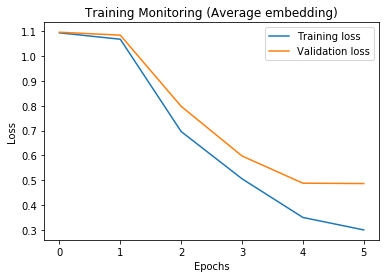

In [20]:
plt.plot(tr_loss, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring (Average embedding)')

plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [21]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x, y in zip(topic_test_ids, topic_test_labels)]
args = topic_test_labels, preds_te

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args, average='macro'))
print('Recall:', recall_score(*args, average='macro'))
print('F1-Score:', f1_score(*args, average='macro'))

Accuracy: 0.8577777777777778
Precision: 0.8575432340880728
Recall: 0.8577777777777778
F1-Score: 0.8572448556010199


## Discuss how did you choose model hyperparameters ?

### Preliminary Analysis

#### Fixed Set Ordering of Vocabulary

The vocabulary is stored as a set object to prevent duplicates. However, Python Sets are unordered collection that do not record element position or order of insertion ([Python Set Types](https://docs.python.org/3.8/library/stdtypes.html#set-types-set-frozenset)). This imples that the order of each vocabulary in the set is not reproducible when the Python kernel is restarted.

After several experiments, it is concluded that different orders of the vocabulary set produce different results. The highest and lowest F1-Score obtained are ~83% and ~81% respectively. To ensure that each set of hyperparameters combination produce the same result (i.e. not affected by ordering of vocabulary), it is decided to sort the vocabulary alphabetically, as shown in the code below.

```python
# Set order is random when kernel is restarted. Use `sorted` for reproducibility
vocab = sorted(dev_vocab.union(train_vocab).union(test_vocab))
```

#### Weight Initialisation Method: He Weight Initialisation

When using ReLU as the activation function and initialising the weights using a uniform distribution method between the same lower and upper boundary (e.g. `np.random.uniform(-0.5, 0.5)`), then by uniform distribution half of the layer will output zero when passing the ReLU activation function ([Glorot et al., 2011](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf)).

[He et al. (2015)](https://arxiv.org/abs/1502.01852) suggested a weight initialisation method that is suitable for the ReLU activation function, as shown below ([Ref 1](https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94), [Ref 2](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)):

```python
np.random.randn(layer_dim[i], layer_dim[i + 1]) * np.sqrt(2 / (layer_dim[i]))
```

Advantages of using He Weight Initialisation:
1. The method is mathematically proven to be effective with ReLU activation function in a published paper (~7810 Google Scholar citations)

2. The weights of each layer is not fixed between the same lower and upper boundary. Now the weights of each layer are multipled by `np.sqrt(2 / (layer_dim[i]))`.

3. The process of hyperparameter optimisation is simpler as the initial boundary of weights (`init_val` in `network_weights`) is excluded.
    1. Manually searching for the optimal initial weights is challenging. The optimal value could depends on the learning rate (`lr`), the embedding dimension (`embedding_dim`). With these dependency relationship between different hyperparameters, having fewer hyperparameters to optimise would greatly reduce the difficulty to find the optimal hyperparameter combination.


#### Relationship Between Hyperparameters and Scores

Before optimising the hyperparameters, it is required to know the relationship between each hyperparameter and the resulting scores.


##### Embedding dimension

The large the embedding dimension, the longer the training time.

- If the embedding dimension is too large, then there might be an excessive amount of information that is not useful. This would have an adverse effect on performance if the model is overfitting.

- If the embedding dimension is too small, then there might not be enough information to represent the word relation.

According to [Yin and Shen (2018)](http://papers.nips.cc/paper/7368-on-the-dimensionality-of-word-embedd), the performance of a word embedding is largely affected by the chosen dimensionality. However, unlike learning rate, there does not seems to be a general rule for choosing embedding dimension.

##### Learning Rate

Choosing a good learning rate is challenging as every model differs from each other. Generally, it is required to perform some preliminary analysis on the model performance before the hyperparameters optimisation.

Learning rate controls how much to change the model in response to the estimated error each time the model weights are updated.

- If the learning rate is too large, the model may overshoot and lead to divergent behaviour (epochs required is low)

- If the learning rate is too small, the model will require many updates to the weights  before the loss is converged (epochs required is high)
    - However, if the tolerance is higher, the training is likely to stop in the first epoch due to early stopping


##### Dropout Rate (Regularisation)

Dropout rate is used to prevent the model from overfitting. If the dropout rate is too high, most of the layer outputs will be ignored, and thus the model would underfit.


### Optimising Hyperparameters

#### Limitations of Trial and Error Method

Although the trial and error method is a straightforward strategy and requires no extra implementation, it is prone to the local optimum problem. It is impractical to try every possible combination of learning rate and regularisation strength to find the optimal result. Therefore, the best achievable performance improvement through fine-tuning is largely dependent on the initial set of values selected to explore the hyperparameters.

Furthermore, another optimisation problem has arisen as the number of hyperparameters to search is more than one. Some hyperparameters could also have a dependency relationship with each other. This has lead to another assumption that the optimisation order of hyperparameters may have a certain impact on the final result.


#### Finding the Baseline Performance

According to the submission instructions, the model should achieve a F1-score of at least 75%. However, the default hyperparameters provided is only getting a F1-score of 37.2%. Therefore, the first step is to find the hyperparameter combination that is able to achieve the baseline performance.

| Trial | embedding_dim |   lr  | dropout | tolerance | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:-------------:|:-----:|:-------:|:---------:|:------:|:--------:|:---------:|:--------:|
|   0   |      300      | 0.001 |   0.2   |    0.01   |    0   |  1.0984  |   1.0986  |  0.3721  |
|   1   |      300      |  0.01 |   0.2   |    0.01   |    0   |  1.0982  |   1.0985  |  0.4255  |
|   2   |      300      |  0.1  |   0.2   |    0.01   |    0   |  1.0959  |   1.0973  |  0.6668  |
|   3   |      300      |  0.2  |   0.2   |    0.01   |    4   |  0.2310  |   0.4400  |  0.8164  |

As shown in the table above, the initial learning rate of 0.001 was too low. After increasing the learning rate to 0.2, the F1-score has improved to 79.5%. As a result, F1-score of 81.6% is set as the baseline peformance. Any subsequent optimisations should therefore be aiming to achieve performance higher than 81.6%.

#### Optimising Learning Rate and Tolerance

In **Finding the Baseline Performance**, the learning rate is increased in big step size, which resulted in small epochs. It would be better for the model to converge with slower speed to prevent the gradient from overshooting.

Fixed parameters: `embedding_dim=300, dropout=0.2`

| Trial |  lr  | tolerance | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:----:|:---------:|:------:|:--------:|:---------:|:--------:|
|   0   |  0.2 |    0.01   |    4   |  0.2310  |   0.4400  |  0.8164  |
|   1   |  0.2 |   0.001   |    4   |  0.2310  |   0.4400  |  0.8164  |
|   2   | 0.15 |    0.01   |    4   |  0.3500  |   0.4881  |  0.8164  |
|   3   | 0.15 |   0.001   |    5   |  0.2997  |   0.4866  |  0.8572  |
|   4   |  0.1 |    0.01   |    0   |  1.0959  |   1.0973  |  0.6668  |
|   5   |  0.1 |   0.001   |    7   |  0.3303  |   0.4705  |  0.8486  |
|   6   | 0.05 |    0.01   |    0   |  1.0973  |   1.0980  |  0.5775  |
|   7   | 0.05 |   0.001   |    0   |  1.0973  |   1.0980  |  0.5775  |

With `lr=0.15, tolerance=0.001`, the model is now able to achieve a F1-score of 85.7%. 

It is observed that for smaller learning rate (< 0.2), both training and validation will decrease very slowly in the first 3 epochs. Therefore, higher tolerance such as 0.01 will stop the training very early, which is why a significant performance improvement is achieved when the tolerance is lowered to 0.001.

#### Optimising Learning Rate

With the tolerance fixed, the learning rate can now be fine-tuned in a small step size to search for possible improvements.

Fixed parameters: `embedding_dim=300, dropout=0.2, tolerance=0.001`

| Trial |   lr   | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:------:|:------:|:--------:|:---------:|:--------:|
|   0   |  0.15  |    5   |  0.2997  |   0.4866  |  0.8572  |
|   1   |  0.16  |    4   |  0.3134  |   0.4680  |  0.8181  |
|   2   |  0.14  |    5   |  0.3293  |   0.5035  |  0.8550  |
|   3   |  0.13  |    7   |  0.2500  |   0.4384  |  0.8470  |
|   4   |  0.145 |    5   |  0.3137  |   0.4939  |  0.8561  |
|   5   | 0.1475 |    5   |  0.3067  |   0.4901  |  0.8572  |
|   6   |  0.151 |    4   |  0.3465  |   0.4859  |  0.8197  |
|   7   | 0.1505 |    5   |  0.2983  |   0.4860  |  0.8560  |

No better `lr` has been found. 0.15 seems to be the maximum limit of the learning rate to achieve the best F1-score with lowest training and validation loss.

#### Optimising Dropout Rate

Compared to other hyperparameters, the dropout rate is relatively easier to optimise as it can only be a value between 0 and 1.

Fixed parameters: `embedding_dim=300, lr=0.15, tolerance=0.001`

| Trial | dropout | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:-------:|:------:|:--------:|:---------:|:--------:|
|   0   |   0.2   |    5   |  0.2997  |   0.4866  |  0.8572  |
|   1   |   0.3   |    7   |  0.2490  |   0.3969  |  0.8053  |
|   2   |   0.4   |    5   |  0.4433  |   0.4704  |  0.8545  |
|   3   |   0.5   |    6   |  0.3479  |   0.4878  |  0.7705  |
|   4   |   0.1   |    4   |  0.2929  |   0.4610  |  0.8055  |
|   5   |   0.19  |    5   |  0.2609  |   0.4490  |  0.8539  |
|   6   |   0.21  |    5   |  0.2963  |   0.4472  |  0.8537  |

No better dropout rate has been found. The initial dropout rate of 0.2 is considered to be the optimal value.


#### Optimising Embedding Dimension

Fixed parameters: `lr=0.15, tolerance=0.001, dropout=0.2`

| Trial | embedding_dim | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:-------------:|:------:|:--------:|:---------:|:--------:|
|   0   |      300      |    5   |  0.2997  |   0.4866  |  0.8572  |
|   1   |      400      |    5   |  0.2723  |   0.3679  |  0.8513  |
|   2   |      500      |    7   |  0.1673  |   0.3869  |  0.8095  |
|   3   |      1000     |    8   |  0.1523  |   0.3579  |  0.8482  |
|   4   |      200      |    2   |  0.6866  |   0.7152  |  0.6770  |
|   5   |      100      |    4   |  0.2890  |   0.4059  |  0.8551  |
|   6   |       50      |    4   |  0.2989  |   0.4216  |  0.7969  |

No better embedding dimension has been found. The initial dimension of 300 is considered to be the optimal value.

According to the table above, there is no clear indiciation whether increasing or decreasing the embedding dimension would have positive or negative effect on the performance.

When the embedding dimension is decreased to 200, the F1-score has to 67.7%. However, the F1-score has increased back to 85.5% after further decreasing the dimension down to 100. Conversely, the performance did not drop below 80% when the dimension is increased up to 1000.


### Summary

Factors that affect the model performance, excluding hyperparameters:
1. The order of the vocabulary

2. The weight initialisation method

The optimal value found for hyperparameters:
1. Embedding dimension: 300
2. Learning rate: 0.15
3. Dropout rate: 0.2
4. Tolerance: 0.001

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [22]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    """
    Args:
        f_zip: The compressed zip file
        f_txt: The text file containing the embeddings
        word2id: The word to vocabulary ID dictionary
        emb_size: The size of the word embeddings
        
    Returns:
        Weights for the embedding layer
    """
    w_emb = np.zeros((len(word2id), emb_size))

    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]

                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] += emb
    return w_emb

In [23]:
w_glove = get_glove_embeddings("glove.840B.300d.zip", "glove.840B.300d.txt",
                               word_to_vocab_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights:

In [24]:
W = network_weights(vocab_size=len(vocab),
                    embedding_dim=300,
                    num_classes=3)
W[0] = w_glove


for i in range(len(W)):
    print(f'Shape W{i} {W[i].shape}')

W, tr_loss, dev_loss = SGD(X_tr=topic_train_ids,
                           Y_tr=topic_train_labels,
                           W=W,
                           X_dev=topic_dev_ids,
                           Y_dev=topic_dev_labels,
                           lr=0.1,
                           dropout=0.2,
                           freeze_emb=True,
                           epochs=100)

Shape W0 (7610, 300)
Shape W1 (300, 3)
Epoch: 0 | Training loss: 0.39196310346400937 | Validation loss: 0.31723636739356187
Epoch: 1 | Training loss: 0.37113303463091457 | Validation loss: 0.2614393910627511
Epoch: 2 | Training loss: 0.32417943335986604 | Validation loss: 0.225559466206273
Epoch: 3 | Training loss: 0.3072251838800586 | Validation loss: 0.22377844162323404
Epoch: 4 | Training loss: 0.30196525400380764 | Validation loss: 0.21991298689775662
Epoch: 5 | Training loss: 0.2921520713493237 | Validation loss: 0.2116361607768931


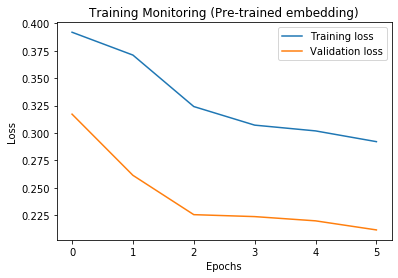

In [25]:
plt.plot(tr_loss, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring (Pre-trained embedding)')

plt.legend()
plt.show()

In [26]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x, y in zip(topic_test_ids, topic_test_labels)]
args = topic_test_labels, preds_te

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args, average='macro'))
print('Recall:', recall_score(*args, average='macro'))
print('F1-Score:', f1_score(*args, average='macro'))

Accuracy: 0.8977777777777778
Precision: 0.897868613832692
Recall: 0.8977777777777778
F1-Score: 0.8967871274658675


## Discuss how did you choose model hyperparameters ?

### Initial Results

Using the optimal hyperparameters obtained in the previous model (average embedding):

Parameters: `embedding_dim=300, lr=0.15, dropout=0.2, tolerance=0.001`

| Epochs | Training loss | Validation loss | Accuracy | Precision | Recall | F1-score |
|:------:|:-------------:|:---------------:|:--------:|:---------:|:------:|:--------:|
|    5   |     0.2798    |      0.2010     |  0.8966  |   0.8965  | 0.8966 |  0.8957  |


### Optimising Hyperparameters

Since the dimension has to be 300 with the GloVe embeddings, there are only two hyperparameters need to optimise: learning rate and dropout rate.

#### Optimising Learning Rate

Fixed parameters: `dropout=0.2, tolerance=0.001`

| Trial |  lr  | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:----:|:------:|:--------:|:---------:|:--------:|
|   0   | 0.15 |    5   |  0.2798  |   0.2010  |  0.8957  |
|   1   |  0.2 |    5   |  0.2754  |   0.1960  |  0.8924  |
|   2   |  0.3 |    5   |  0.2807  |   0.1962  |  0.8944  |
|   3   |  0.4 |    3   |  0.2777  |   0.1968  |  0.8800  |
|   4   |  0.1 |    5   |  0.2921  |   0.2116  |  0.8967  |
|   5   | 0.05 |    3   |  0.3343  |   0.2523  |  0.8776  |
|   6   | 0.01 |   11   |  0.3594  |   0.2760  |  0.8837  |

`lr=0.1` has the highest F1-score of 89.67%, therefore it is selected as the optimal learning rate. Although it has about 1% higher training and validation loss than `lr=0.15`, but the aim of hyperparameters optimisation is to achieve the highest possible scores.

According to the results, changing the learning rate only produce a ± 2% performance differences. It is also observed that the validation loss is always lower than the training loss in this model.


#### Optimising Dropout Rate

Fixed parameters: `lr=0.1, tolerance=0.001`

| Trial | dropout | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:-------:|:------:|:--------:|:---------:|:--------:|
|   0   |   0.2   |    5   |  0.2921  |   0.2116  |  0.8967  |
|   1   |   0.1   |    2   |  0.3206  |   0.2033  |  0.8861  |
|   2   |   0.3   |    3   |  0.3317  |   0.2379  |  0.8868  |
|   3   |   0.5   |    3   |  0.3923  |   0.3119  |  0.8757  |
|   4   |   0.7   |    7   |  0.4672  |   0.3993  |  0.8879  |
|   5   |   0.9   |   11   |  0.7462  |   0.7007  |  0.8809  |

No better dropout rate has been found. `dropout=0.2` has the best F1-score with lowest training and validation loss.


### Summary

According to the results in the tables above, the performance of **Pre-Trained Embeddings Model** is not affected significantly by the value of learning rate and dropout rate. In comparison with **Average Embeddings Model**, it is safe to conclude that the performance this feedforward network is largely dependent on the initial weights.

The optimal value found for hyperparameters:
1. Learning rate: 0.1
2. Dropout rate: 0.2

Using pre-trained embeddings improved the total performance by ~4% in comparison to randomly initialising the embedding weights matrix.

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [27]:
W = network_weights(vocab_size=len(vocab),
                    embedding_dim=300,
                    hidden_dim=[1050],
                    num_classes=3)
W[0] = w_glove

for i in range(len(W)):
    print(f'Shape W{i} {W[i].shape}')

W, tr_loss, dev_loss = SGD(X_tr=topic_train_ids,
                           Y_tr=topic_train_labels,
                           W=W,
                           X_dev=topic_dev_ids,
                           Y_dev=topic_dev_labels,
                           lr=0.07,
                           dropout=0.2,
                           freeze_emb=True,
                           early_stopping=False,
                           epochs=5)

Shape W0 (7610, 300)
Shape W1 (300, 1050)
Shape W2 (1050, 3)
Epoch: 0 | Training loss: 0.42479884818659164 | Validation loss: 0.367079861662041
Epoch: 1 | Training loss: 0.41608202469722905 | Validation loss: 0.34109356664542934
Epoch: 2 | Training loss: 0.4626220294584154 | Validation loss: 0.446505678173534
Epoch: 3 | Training loss: 0.3572658445781216 | Validation loss: 0.27464592135579863
Epoch: 4 | Training loss: 0.35519588083525444 | Validation loss: 0.2802350066339664


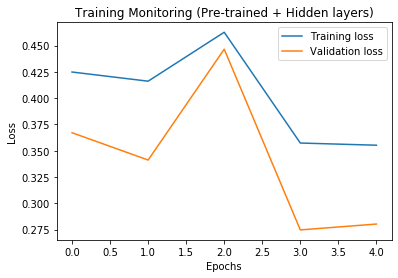

In [28]:
plt.plot(tr_loss, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring (Pre-trained + Hidden layers)')

plt.legend()
plt.show()

In [29]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x, y in zip(topic_test_ids, topic_test_labels)]
args = topic_test_labels, preds_te

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args, average='macro'))
print('Recall:', recall_score(*args, average='macro'))
print('F1-Score:', f1_score(*args, average='macro'))

Accuracy: 0.9033333333333333
Precision: 0.9031030443799583
Recall: 0.9033333333333333
F1-Score: 0.9020881592476028


## Discuss how did you choose model hyperparameters ?

### Searching the First Hidden Layer Dimension

The first step is to find the hyperparameter combination that is able to achieve the closest performance to **Pre-trained Embeddings Model**.

| Trial | hidden_dim |  lr  | dropout | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:----------:|:----:|:-------:|:------:|:--------:|:---------:|:--------:|
|   0   |     100    |  0.1 |   0.2   |    1   |   0.618  |   0.5411  |  0.8293  |
|   1   |     200    |  0.1 |   0.2   |    1   |  0.5676  |   0.5865  |  0.8777  |
|   2   |     300    |  0.1 |   0.2   |    2   |  0.4808  |   0.4006  |  0.8517  |
|   3   |     200    | 0.05 |   0.2   |    4   |  0.5609  |   0.5045  |  0.8727  |
|   4   |     200    | 0.05 |   0.1   |    5   |  0.4562  |   0.4156  |  0.8697  |
|   5   |    1000    | 0.05 |   0.1   |    3   |  0.3257  |   0.2171  |  0.8913  |
|   6   |    1000    | 0.05 |   0.2   |    3   |  0.3623  |   0.2515  |  0.8953  |

The hyperparameter combination `hidden_dim=[1000], lr=0.05, dropout=0.2` has achieve a F1-score of 89.53%, which is only 0.14% lower than **Pre-trained Embeddings Model**.

### Relationship between Hyperparameters and Loss

According to the table in **Searching the First Hidden Layer Dimension**,

1. Increasing hidden layer dimension will decrease training loss

2. Increasing dropout rate will increase training and validation loss

The aim is to adjust each hyperparameter appropriately to reach about 30% final training loss and 20% final validation loss. The model appear to be producing the best performance when both losses fall into the respective range.

### Further Trial and Error

| Trial | hidden_dim |   lr  | dropout | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:----------:|:-----:|:-------:|:------:|:--------:|:---------:|:--------:|
|   0   |     500    |  0.05 |   0.2   |    3   |  0.4220  |   0.3357  |  0.8683  |
|   1   |     500    |  0.1  |   0.2   |    3   |  0.4073  |   0.3223  |  0.8702  |
|   2   |     500    |  0.2  |   0.2   |    3   |  0.4212  |   0.3500  |  0.8689  |
|   3   |     600    |  0.2  |   0.2   |    0   |  0.5173  |   0.3960  |  0.8327  |
|   4   |     600    |  0.1  |   0.3   |    2   |  0.4654  |   0.3992  |  0.8704  |
|   5   |    1000    |  0.01 |   0.3   |   10   |  0.4389  |   0.3525  |  0.8928  |
|   6   |    1100    |  0.01 |   0.3   |    6   |  0.4626  |   0.4242  |  0.8938  |
|   7   |    1200    |  0.01 |   0.3   |    4   |  0.4719  |   0.4409  |  0.8889  |
|   8   |    1100    | 0.012 |   0.3   |    2   |  0.5108  |   0.4725  |  0.8936  |
|   9   |    1100    |  0.12 |   0.25  |    2   |  0.4661  |   0.4189  |  0.8926  |

No better hyperparameter values have been found. 


### Disable Early Stopping

After further analysis, it is observed that the overall trend of validation loss is decreasing. However, there would be irregular "spikes" that trigger early stopping and stop the training process earlier then the optimal case.

To address this issue, an extra argument `early_stopping` is added to the `SGD()` function. As a result, the training process is now controlled by the `epochs` parameter.

| Trial | hidden_dim |   lr  | dropout | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:----------:|:-----:|:-------:|:------:|:--------:|:---------:|:--------:|
|   0   | 1000       | 0.05  | 0.2     | 5      | 0.3482   | 0.2765    | 0.8953   |
|   1   | 1050       | 0.05  | 0.2     | 5      | 0.3568   | 0.2853    | 0.9011   |
|   2   | 1100       | 0.05  | 0.2     | 5      | 0.3710   | 0.2544    | 0.8935   |
|   3   | 1050       | 0.055 | 0.15    | 5      | 0.3198   | 0.2445    | 0.8980   |
|   4   | 1050       | 0.055 | 0.2     | 5      | 0.3559   | 0.2835    | 0.9011   |
|   5   | 1050       | 0.06  | 0.2     | 5      | 0.3553   | 0.2821    | 0.9011   |
|   6   | 1050       | 0.07  | 0.2     | 5      | 0.3551   | 0.2802    | 0.9020   |
|   7   | 1050       | 0.08  | 0.2     | 5      | 0.3559   | 0.2791    | 0.9009   |
|   8   | 1050       | 0.075 | 0.2     | 5      | 0.3554   | 0.2796    | 0.9020   |
|   9   | 1050       | 0.07  | 0.2     | 10     | 0.3706   | 0.2861    | 0.8824   |

The hyperparameter values `hidden_dim=[1050], lr=0.07, dropout=0.2, epochs=5` has achieved a F1-score of 90.2%.


### Attempts on Double Hidden Layer Dimensions

| Trial | hidden_dim |  lr  | dropout | Epochs | Tr. loss | Val. loss | F1-score |
|:-----:|:----------:|:----:|:-------:|:------:|:--------:|:---------:|:--------:|
|   0   | 525, 525   | 0.07 | 0.2     | 5      | 0.3783   | 0.2741    | 0.8973   |
|   1   | 1000, 50   | 0.07 | 0.2     | 5      | 0.4345   | 0.2467    | 0.8920   |
|   2   | 1000, 50   | 0.1  | 0.2     | 5      | 0.4678   | 0.2628    | 0.8954   |
|   3   | 1000, 50   | 0.15 | 0.2     | 5      | 0.4882   | 0.3367    | 0.8927   |
|   4   | 1000, 50   | 0.1  | 0.2     | 10     | 0.4033   | 0.2668    | 0.8862   |
|   5   | 300, 300   | 0.1  | 0.2     | 10     | 0.4323   | 0.4404    | 0.8743   |

Unfortunately, the attemps on double hidden layer dimensions did not manage to achieve a new high score.


### Summary

1. Adding a hidden layer will increase the training time due to the extra dimensions, but this does not ensure that a good performance will be produced.

2. According to the optimisation attemps, the lowest F1-score obtained is 82.93% in **Searching the First Hidden Layer Dimension**. Therefore, this model is still better than **Average Embedding Model** considering that it requires more optimisation effort and has higher implementation complexity.

3. As shown in the plot **Training Monitoring - (Pre-trained + Hidden layers)** above, the sudden "spike" increase of both training and validation does not always indicate a negative outcome. The model still managed to achieve a 90.2% of F1-score in this case.

4. It is shown that the performance of **Pre-Trained Embeddings + Hidden Layer Model** can be better than **Pre-Trained Embeddings Model**. However, a significant amount of time is required to adjust each hyperparameters to achieve the optimal result.

# Full Results

|                           Model                           | Accuracy | Precision | Recall | F1-Score |
|:---------------------------------------------------------:|:--------:|:---------:|:------:|:--------:|
|                     Average Embedding                     |  0.8577  |   0.8575  | 0.8577 |  0.8572  |
|              Average Embedding (Pre-trained)              |  0.8977  |   0.8979  | 0.8977 |  0.8967  |
| Average Embedding (Pre-trained) + X hidden layers (BONUS) |  0.9033  |   0.9031  | 0.9033 |  0.9020  |